In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sun Jan 10 15:33:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 30%   42C    P8    41W / 250W |      1MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '10Jan2021_TracksToHists_B_Iter4_100epochs_lr_2em3_b32_2p5_kde2hists_float_KDE_to_Hists'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
## learning rate was 1e-7 for all layers in TracksToHists_A
## here we want to learn only weights in the finalFilter layer
## of TracksToHists_B, so try a high learning rate, at least initially
## 1e-3 did well for the first 10 epochs; let's increase it for the next 40
## reduce to 1e-3 for iteration with KDE_to_Hists weights floated
##  cost decreased monotonically in previous run, so increase lr to 2e-3
## iter 3 training cost still descreasing monotonically, so leave lr = 2e-3 for iter 4
learning_rate = 2e-3

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_B as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## 210109 let's use some of Will's toy MC for training rather than the 20K sample I've been using

##train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
train_loader = collect_t2hists_data('/share/lazy/will/data/June30_2020_80k_1.h5',    
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
##                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,

## 210109 and use everything in this 20K file for validation
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
##                           slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
len(X) =  80000
len(Xlist) =  1
Loaded /share/lazy/will/data/June30_2020_80k_1.h5 in 115.0 s
outer loop X.shape =  (80000, 9, 600)
Constructing 80000 event dataset took 0.7557 s
x_t.shape =  torch.Size([80000, 9, 600])
x_t.shape[0] =  80000
x_t.shape[1] =  9
x_t.shape =  torch.Size([80000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTr

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa

## 210110 For Iter0, freeze all weights other than those asociated with
## the finalFilter added in moving from TracksToHists_A to TracksToHists_B

## for "float_KDE_to_Hists" loop over ct<17
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 17) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  0 params
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  1 params
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  2 params
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  3 params
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  4 params
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  5 params
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
     About to set param.requires_grad=False for ct =  6 params
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
     Abo

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '10Jan2021_TracksToHists_B_Iter3_20epochs_lr_2em3_2p5_kde2hists_float_KDE_to_Hists'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


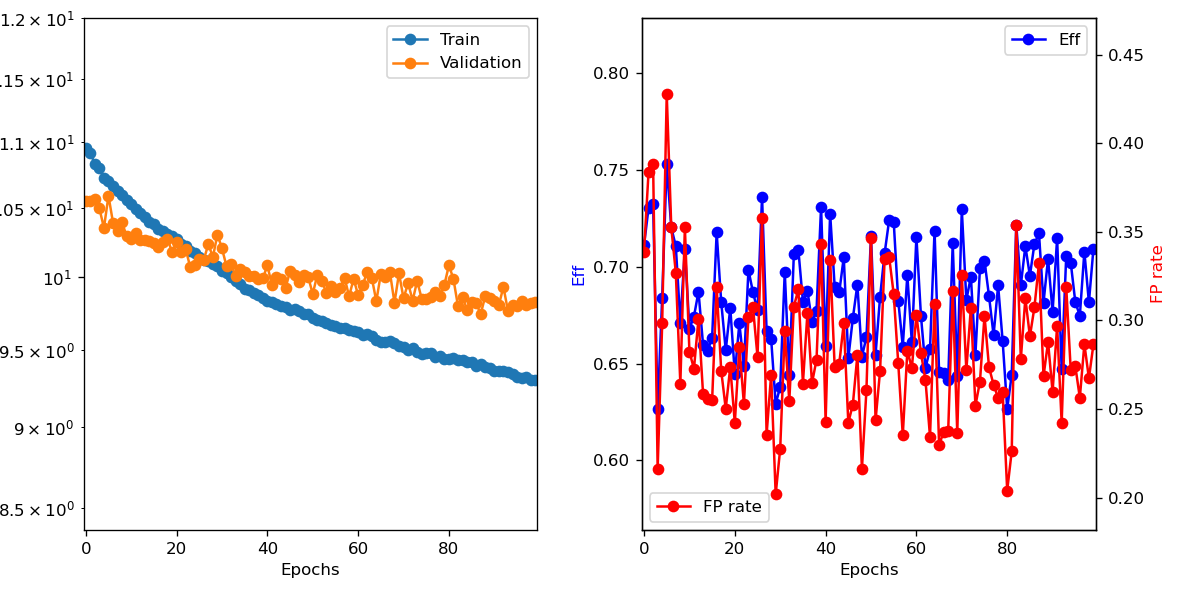

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1250, val = 313


Epoch 0: train=10.9543, val=10.5474, took 90.753 s
  Validation Found 76828 of 108024, added 6776 (eff 71.12%) (0.339 FP/event)


Epoch 1: train=10.9102, val=10.5532, took 95.123 s
  Validation Found 78912 of 108024, added 7677 (eff 73.05%) (0.384 FP/event)


Epoch 2: train=10.8322, val=10.5617, took 90.958 s
  Validation Found 79153 of 108024, added 7765 (eff 73.27%) (0.388 FP/event)


Epoch 3: train=10.801, val=10.4949, took 90.605 s
  Validation Found 67705 of 108024, added 4324 (eff 62.68%) (0.216 FP/event)


Epoch 4: train=10.724, val=10.3529, took 90.638 s
  Validation Found 73895 of 108024, added 5967 (eff 68.41%) (0.298 FP/event)


Epoch 5: train=10.6963, val=10.5884, took 90.464 s
  Validation Found 81379 of 108024, added 8559 (eff 75.33%) (0.428 FP/event)


Epoch 6: train=10.665, val=10.3906, took 90.386 s
  Validation Found 77821 of 108024, added 7055 (eff 72.04%) (0.353 FP/event)


Epoch 7: train=10.6231, val=10.3291, took 90.908 s
  Validation Found 76781 of 108024, added 6539 (eff 71.08%) (0.327 FP/event)


Epoch 8: train=10.5916, val=10.3932, took 90.629 s
  Validation Found 72490 of 108024, added 5287 (eff 67.11%) (0.264 FP/event)


Epoch 9: train=10.5579, val=10.2906, took 90.966 s
  Validation Found 76643 of 108024, added 7050 (eff 70.95%) (0.352 FP/event)


Epoch 10: train=10.5271, val=10.2746, took 90.688 s
  Validation Found 72177 of 108024, added 5645 (eff 66.82%) (0.282 FP/event)


Epoch 11: train=10.4934, val=10.3158, took 90.607 s
  Validation Found 72852 of 108024, added 5456 (eff 67.44%) (0.273 FP/event)


Epoch 12: train=10.4643, val=10.2625, took 90.899 s
  Validation Found 74242 of 108024, added 6021 (eff 68.73%) (0.301 FP/event)


Epoch 13: train=10.4312, val=10.2643, took 90.645 s
  Validation Found 71288 of 108024, added 5175 (eff 65.99%) (0.259 FP/event)


Epoch 14: train=10.3961, val=10.2588, took 90.549 s
  Validation Found 70913 of 108024, added 5109 (eff 65.65%) (0.255 FP/event)


Epoch 15: train=10.3803, val=10.2418, took 90.489 s
  Validation Found 71662 of 108024, added 5098 (eff 66.34%) (0.255 FP/event)


Epoch 16: train=10.3478, val=10.2173, took 90.662 s
  Validation Found 77551 of 108024, added 6378 (eff 71.79%) (0.319 FP/event)


Epoch 17: train=10.3277, val=10.2531, took 90.688 s
  Validation Found 73670 of 108024, added 5434 (eff 68.20%) (0.272 FP/event)


Epoch 18: train=10.3057, val=10.2741, took 90.643 s
  Validation Found 70967 of 108024, added 5004 (eff 65.70%) (0.25 FP/event)


Epoch 19: train=10.2927, val=10.1772, took 90.673 s
  Validation Found 73338 of 108024, added 5476 (eff 67.89%) (0.274 FP/event)


Epoch 20: train=10.2727, val=10.2536, took 90.681 s
  Validation Found 69648 of 108024, added 4842 (eff 64.47%) (0.242 FP/event)


Epoch 21: train=10.2359, val=10.1751, took 90.689 s
  Validation Found 72470 of 108024, added 5702 (eff 67.09%) (0.285 FP/event)


Epoch 22: train=10.2185, val=10.1994, took 90.65 s
  Validation Found 70097 of 108024, added 5057 (eff 64.89%) (0.253 FP/event)


Epoch 23: train=10.1867, val=10.0723, took 90.715 s
  Validation Found 75449 of 108024, added 6035 (eff 69.84%) (0.302 FP/event)


Epoch 24: train=10.1732, val=10.0838, took 90.599 s
  Validation Found 74210 of 108024, added 6150 (eff 68.70%) (0.307 FP/event)


Epoch 25: train=10.1442, val=10.1292, took 90.48 s
  Validation Found 73201 of 108024, added 5590 (eff 67.76%) (0.279 FP/event)


Epoch 26: train=10.1181, val=10.1241, took 90.672 s
  Validation Found 79537 of 108024, added 7159 (eff 73.63%) (0.358 FP/event)


Epoch 27: train=10.1144, val=10.234, took 90.655 s
  Validation Found 72041 of 108024, added 4712 (eff 66.69%) (0.236 FP/event)


Epoch 28: train=10.0935, val=10.1421, took 90.587 s
  Validation Found 71618 of 108024, added 5387 (eff 66.30%) (0.269 FP/event)


Epoch 29: train=10.0811, val=10.304, took 90.558 s
  Validation Found 67977 of 108024, added 4037 (eff 62.93%) (0.202 FP/event)


Epoch 30: train=10.0427, val=10.2045, took 90.609 s
  Validation Found 68925 of 108024, added 4553 (eff 63.81%) (0.228 FP/event)


Epoch 31: train=10.0254, val=10.0764, took 90.632 s
  Validation Found 75348 of 108024, added 5878 (eff 69.75%) (0.294 FP/event)


Epoch 32: train=9.99951, val=10.0933, took 90.601 s
  Validation Found 69596 of 108024, added 5086 (eff 64.43%) (0.254 FP/event)


Epoch 33: train=9.97541, val=10.008, took 90.574 s
  Validation Found 76322 of 108024, added 6157 (eff 70.65%) (0.308 FP/event)


Epoch 34: train=9.94859, val=10.0569, took 90.596 s
  Validation Found 76574 of 108024, added 6350 (eff 70.89%) (0.317 FP/event)


Epoch 35: train=9.91912, val=10.0341, took 90.503 s
  Validation Found 73677 of 108024, added 5288 (eff 68.20%) (0.264 FP/event)


Epoch 36: train=9.90622, val=10.01, took 90.721 s
  Validation Found 74289 of 108024, added 6089 (eff 68.77%) (0.304 FP/event)


Epoch 37: train=9.89185, val=10.0088, took 90.926 s
  Validation Found 72552 of 108024, added 5293 (eff 67.16%) (0.265 FP/event)


Epoch 38: train=9.87567, val=9.98686, took 90.758 s
  Validation Found 73187 of 108024, added 5557 (eff 67.75%) (0.278 FP/event)


Epoch 39: train=9.85641, val=9.99005, took 90.775 s
  Validation Found 78975 of 108024, added 6858 (eff 73.11%) (0.343 FP/event)


Epoch 40: train=9.835, val=10.0825, took 90.385 s
  Validation Found 71185 of 108024, added 4859 (eff 65.90%) (0.243 FP/event)


Epoch 41: train=9.82413, val=9.94316, took 90.711 s
  Validation Found 78594 of 108024, added 6686 (eff 72.76%) (0.334 FP/event)


Epoch 42: train=9.81362, val=9.99928, took 90.674 s
  Validation Found 74506 of 108024, added 5469 (eff 68.97%) (0.273 FP/event)


Epoch 43: train=9.7982, val=9.98532, took 90.689 s
  Validation Found 74195 of 108024, added 5509 (eff 68.68%) (0.275 FP/event)


Epoch 44: train=9.79008, val=9.92297, took 90.634 s
  Validation Found 76161 of 108024, added 5971 (eff 70.50%) (0.299 FP/event)


Epoch 45: train=9.76824, val=10.0409, took 90.807 s
  Validation Found 70513 of 108024, added 4846 (eff 65.28%) (0.242 FP/event)


Epoch 46: train=9.77627, val=10.0153, took 90.649 s
  Validation Found 72757 of 108024, added 5051 (eff 67.35%) (0.253 FP/event)


Epoch 47: train=9.76272, val=9.96884, took 90.726 s
  Validation Found 74638 of 108024, added 5609 (eff 69.09%) (0.28 FP/event)


Epoch 48: train=9.74644, val=10.017, took 90.759 s
  Validation Found 70614 of 108024, added 4324 (eff 65.37%) (0.216 FP/event)


Epoch 49: train=9.74284, val=9.99892, took 90.693 s
  Validation Found 71703 of 108024, added 5220 (eff 66.38%) (0.261 FP/event)


Epoch 50: train=9.71274, val=9.88251, took 90.621 s
  Validation Found 77340 of 108024, added 6934 (eff 71.60%) (0.347 FP/event)


Epoch 51: train=9.70383, val=10.015, took 90.787 s
  Validation Found 70715 of 108024, added 4873 (eff 65.46%) (0.244 FP/event)


Epoch 52: train=9.69408, val=9.97411, took 90.441 s
  Validation Found 73956 of 108024, added 5432 (eff 68.46%) (0.272 FP/event)


Epoch 53: train=9.68206, val=9.88859, took 90.659 s
  Validation Found 76382 of 108024, added 6696 (eff 70.71%) (0.335 FP/event)


Epoch 54: train=9.66578, val=9.93816, took 90.485 s
  Validation Found 78242 of 108024, added 6716 (eff 72.43%) (0.336 FP/event)


Epoch 55: train=9.66049, val=9.89809, took 90.646 s
  Validation Found 78150 of 108024, added 6297 (eff 72.35%) (0.315 FP/event)


Epoch 56: train=9.64753, val=9.91994, took 90.544 s
  Validation Found 73744 of 108024, added 5516 (eff 68.27%) (0.276 FP/event)


Epoch 57: train=9.64499, val=9.99684, took 90.631 s
  Validation Found 71176 of 108024, added 4702 (eff 65.89%) (0.235 FP/event)


Epoch 58: train=9.63273, val=9.86505, took 90.681 s
  Validation Found 75161 of 108024, added 5656 (eff 69.58%) (0.283 FP/event)


Epoch 59: train=9.62764, val=9.98724, took 90.997 s
  Validation Found 71403 of 108024, added 5463 (eff 66.10%) (0.273 FP/event)


Epoch 60: train=9.61728, val=9.87295, took 90.579 s
  Validation Found 77318 of 108024, added 6064 (eff 71.57%) (0.303 FP/event)


Epoch 61: train=9.59945, val=9.94342, took 90.668 s
  Validation Found 72898 of 108024, added 5635 (eff 67.48%) (0.282 FP/event)


Epoch 62: train=9.60493, val=10.0381, took 90.719 s
  Validation Found 69976 of 108024, added 5325 (eff 64.78%) (0.266 FP/event)


Epoch 63: train=9.59408, val=9.99598, took 90.669 s
  Validation Found 71046 of 108024, added 4686 (eff 65.77%) (0.234 FP/event)


Epoch 64: train=9.5653, val=9.83134, took 90.675 s
  Validation Found 77650 of 108024, added 6187 (eff 71.88%) (0.309 FP/event)


Epoch 65: train=9.55354, val=10.0238, took 90.918 s
  Validation Found 69739 of 108024, added 4594 (eff 64.56%) (0.23 FP/event)


Epoch 66: train=9.55381, val=10.0015, took 90.968 s
  Validation Found 69698 of 108024, added 4741 (eff 64.52%) (0.237 FP/event)


Epoch 67: train=9.56159, val=10.0327, took 90.656 s
  Validation Found 69303 of 108024, added 4748 (eff 64.16%) (0.237 FP/event)


Epoch 68: train=9.54846, val=9.82055, took 90.706 s
  Validation Found 76936 of 108024, added 6327 (eff 71.22%) (0.316 FP/event)


Epoch 69: train=9.52876, val=10.0272, took 90.767 s
  Validation Found 69550 of 108024, added 4731 (eff 64.38%) (0.237 FP/event)


Epoch 70: train=9.51673, val=9.85032, took 90.623 s
  Validation Found 78834 of 108024, added 6513 (eff 72.98%) (0.326 FP/event)


Epoch 71: train=9.4987, val=9.95941, took 90.559 s
  Validation Found 73773 of 108024, added 5437 (eff 68.29%) (0.272 FP/event)


Epoch 72: train=9.51361, val=9.8354, took 90.564 s
  Validation Found 75072 of 108024, added 6146 (eff 69.50%) (0.307 FP/event)


Epoch 73: train=9.48747, val=9.97319, took 90.908 s
  Validation Found 70717 of 108024, added 5038 (eff 65.46%) (0.252 FP/event)


Epoch 74: train=9.47521, val=9.84793, took 90.738 s
  Validation Found 75546 of 108024, added 5310 (eff 69.93%) (0.265 FP/event)


Epoch 75: train=9.47643, val=9.84508, took 90.77 s
  Validation Found 75958 of 108024, added 6054 (eff 70.32%) (0.303 FP/event)


Epoch 76: train=9.47779, val=9.86355, took 90.845 s
  Validation Found 73989 of 108024, added 5471 (eff 68.49%) (0.274 FP/event)


Epoch 77: train=9.44989, val=9.89697, took 91.205 s
  Validation Found 71807 of 108024, added 5274 (eff 66.47%) (0.264 FP/event)


Epoch 78: train=9.45816, val=9.86502, took 91.187 s
  Validation Found 74588 of 108024, added 5125 (eff 69.05%) (0.256 FP/event)


Epoch 79: train=9.4413, val=9.9468, took 91.128 s
  Validation Found 71477 of 108024, added 5187 (eff 66.17%) (0.259 FP/event)


Epoch 80: train=9.43824, val=10.0839, took 91.233 s
  Validation Found 67699 of 108024, added 4080 (eff 62.67%) (0.204 FP/event)


Epoch 81: train=9.4441, val=9.9842, took 91.01 s
  Validation Found 69604 of 108024, added 4524 (eff 64.43%) (0.226 FP/event)


Epoch 82: train=9.43237, val=9.79573, took 91.247 s
  Validation Found 77969 of 108024, added 7079 (eff 72.18%) (0.354 FP/event)


Epoch 83: train=9.43328, val=9.85982, took 91.639 s
  Validation Found 74589 of 108024, added 5563 (eff 69.05%) (0.278 FP/event)


Epoch 84: train=9.42281, val=9.77057, took 93.272 s
  Validation Found 76787 of 108024, added 6252 (eff 71.08%) (0.313 FP/event)


Epoch 85: train=9.41769, val=9.82797, took 93.289 s
  Validation Found 75120 of 108024, added 5820 (eff 69.54%) (0.291 FP/event)


Epoch 86: train=9.39479, val=9.81682, took 93.253 s
  Validation Found 76908 of 108024, added 6149 (eff 71.20%) (0.307 FP/event)


Epoch 87: train=9.40395, val=9.74409, took 93.159 s
  Validation Found 77486 of 108024, added 6647 (eff 71.73%) (0.332 FP/event)


Epoch 88: train=9.38472, val=9.86689, took 93.765 s
  Validation Found 73621 of 108024, added 5369 (eff 68.15%) (0.268 FP/event)


Epoch 89: train=9.38214, val=9.85527, took 93.256 s
  Validation Found 76087 of 108024, added 5757 (eff 70.44%) (0.288 FP/event)


Epoch 90: train=9.35813, val=9.83107, took 93.853 s
  Validation Found 73101 of 108024, added 5195 (eff 67.67%) (0.26 FP/event)


Epoch 91: train=9.35771, val=9.806, took 93.492 s
  Validation Found 77243 of 108024, added 5938 (eff 71.51%) (0.297 FP/event)


Epoch 92: train=9.35713, val=9.93103, took 92.414 s
  Validation Found 69900 of 108024, added 4841 (eff 64.71%) (0.242 FP/event)


Epoch 93: train=9.35213, val=9.76467, took 92.109 s
  Validation Found 76222 of 108024, added 6381 (eff 70.56%) (0.319 FP/event)


Epoch 94: train=9.34102, val=9.80862, took 93.654 s
  Validation Found 75854 of 108024, added 5438 (eff 70.22%) (0.272 FP/event)


Epoch 95: train=9.32085, val=9.79976, took 92.518 s
  Validation Found 73667 of 108024, added 5488 (eff 68.20%) (0.274 FP/event)


Epoch 96: train=9.31646, val=9.8324, took 92.492 s
  Validation Found 72896 of 108024, added 5127 (eff 67.48%) (0.256 FP/event)


Epoch 97: train=9.31824, val=9.80195, took 92.311 s
  Validation Found 76479 of 108024, added 5734 (eff 70.80%) (0.287 FP/event)


Epoch 98: train=9.30332, val=9.81914, took 92.352 s
  Validation Found 73638 of 108024, added 5347 (eff 68.17%) (0.267 FP/event)


Epoch 99: train=9.29805, val=9.82621, took 92.359 s
  Validation Found 76645 of 108024, added 5731 (eff 70.95%) (0.287 FP/event)



In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


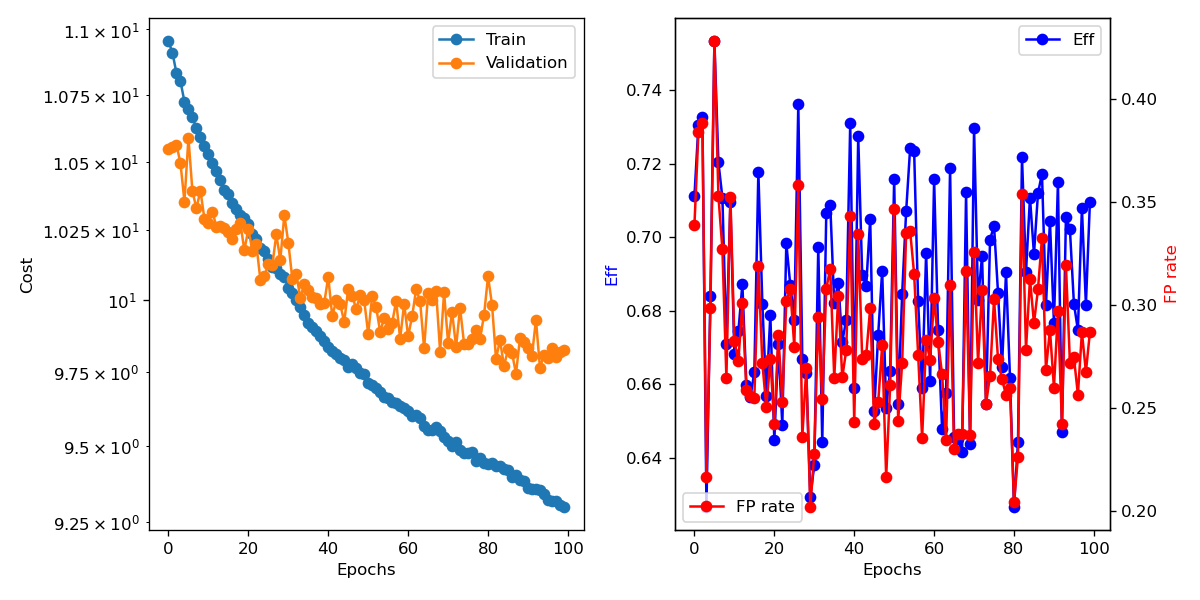

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [1]:
##torch.cuda.empty_cache()"
##quit()

